<a href="https://colab.research.google.com/github/nraptis/Machine-Learning-Notebooks/blob/main/Customer_Churn_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Customer Churn Model Using XGBoost Framework

### 1. Customer Retention Retail Dataset

This dataset can be used to understand what are the various marketing strategy based on consumer behaviour that can be adopted to increase customer retention of a retail store.

An online tea retail store which sells tea of different flavors across various cities in India. The dataset contains data about the store's customers, their orders, quantity ordered, order frequency, city,etc. This is a large dataset which will help in analysis.

Reference: https://www.kaggle.com/uttamp/store-data

In [ ]:
%%html
<style>
table {float:left}
</style>

| column | Description
|--|--|
| custid | Computer generated ID to identify customers throughout the database
|retained |	1, if customer is assumed to be active, 0 = otherwise
|created | Date when the contact was created in the database - when the customer joined
|firstorder | Date when the customer placed first order
|lastorder | Date when the customer placed last order
|esent |	Number of emails sent
|eopenrate | Number of emails opened divided by number of emails sent
|eclickrate | Number of emails clicked divided by number of emails sent
|avgorder | Average order size for the customer
|ordfreq | Number of orders divided by customer tenure
|paperless | 1 if customer subscribed for paperless communication (only online)
|refill | 1 if customer subscribed for automatic refill
|doorstep | 1 if customer subscribed for doorstep delivery
|train | 1 if customer is in the training database
|favday | Customer's favorite delivery day
|city | City where the customer resides in

### 2. Import Packages and Constants

Install shap and smdebug packages if not already installed and restart kernel after installing the packages

In [ ]:
import sys

#!{sys.executable} -m pip uninstall -y shap numpy
#!{sys.executable} -m pip install "numpy==1.26.4" "shap==0.49.1"
#!pip install smdebug --upgrade
#!{sys.executable} -m pip install -U shap

In [ ]:
import numpy as np, pandas as pd, shap, sklearn
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("shap", shap.__version__)
print("sklearn", sklearn.__version__)

numpy 2.3.5
pandas 2.3.3
shap 0.50.0
sklearn 1.7.2


In [ ]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

In [ ]:
default_bucket = "sagemaker-us-east-2-005200800801"
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


### 3. Preprocess Data

In [ ]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df
storedata = preprocess_data(f"s3://{default_bucket}/data/storedata_total.csv")

# Ensure booleans are numeric
for c in storedata.columns:
    if storedata[c].dtype == bool:
        storedata[c] = storedata[c].astype(int)

storedata.head(3)

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,0,0,0,0,0,1,0,0,1,0


### 4. Split Train, Test and Validation Datasets

In [ ]:
def split_datasets_sklearn(
    df: pd.DataFrame,
    label_col: str = "retained",
    train_frac: float = 0.70,
    val_frac: float = 0.15,
    test_frac: float = 0.15,
    seed: int = 1337,
):
    # --- basic invariants ---
    total = train_frac + val_frac + test_frac
    if abs(total - 1.0) > 1e-9:
        raise ValueError(f"Fractions must sum to 1.0, got {total}")

    if label_col not in df.columns:
        raise KeyError(f"Missing label col '{label_col}' in df.columns")

    df = df.copy(deep=True)

    # --- split X/y (keep names!) ---
    y = df[label_col].astype(int)
    X = df.drop(columns=[label_col])
    feature_names = list(X.columns)

    # --- prove label is binary-ish ---
    uniq = sorted(y.unique().tolist())
    print("Label unique values:", uniq)
    if not set(uniq).issubset({0, 1}):
        raise ValueError(f"Label '{label_col}' must be 0/1, got {uniq}")

    # --- first split: train vs temp ---
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y,
        test_size=(1.0 - train_frac),
        stratify=y,
        random_state=seed
    )

    # --- second split: val vs test from temp ---
    # temp fraction = val + test. We want val_frac / (val+test) of temp for val.
    temp_total = val_frac + test_frac
    val_share_of_temp = val_frac / temp_total  # e.g. 0.15 / 0.30 = 0.5

    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp,
        test_size=(1.0 - val_share_of_temp),
        stratify=y_tmp,
        random_state=seed
    )

    # --- print sanity stats ---
    def report(name, Xp, yp):
        n = len(yp)
        pos = int(yp.sum())
        neg = n - pos
        pos_rate = (pos / n) if n else float("nan")
        print(f"{name:>6}: X={Xp.shape}  y={yp.shape}  pos={pos}  neg={neg}  pos_rate={pos_rate:.4f}")

    print("\nSplit summary:")
    report("train", X_train, y_train)
    report("val",   X_val,   y_val)
    report("test",  X_test,  y_test)

    # --- prove there are no column mismatches ---
    assert list(X_train.columns) == feature_names
    assert list(X_val.columns)   == feature_names
    assert list(X_test.columns)  == feature_names

    # --- show a tiny peek, but not a spam scroll ---
    print("\nFirst 5 y_train:", y_train.head(5).tolist())
    print("First 10 feature names:", feature_names[:10])
    print("First row (first 10 features):")
    display(X_train.iloc[[0], :10])

    return feature_names, X_train, y_train, X_val, y_val, X_test, y_test
feature_names, X_train, y_train, X_val, y_val, X_test, y_test = split_datasets_sklearn(storedata)


Label unique values: [0, 1]

Split summary:
 train: X=(21530, 21)  y=(21530,)  pos=17107  neg=4423  pos_rate=0.7946
   val: X=(4614, 21)  y=(4614,)  pos=3666  neg=948  pos_rate=0.7945
  test: X=(4614, 21)  y=(4614,)  pos=3666  neg=948  pos_rate=0.7945

First 5 y_train: [1, 1, 1, 1, 1]
First 10 feature names: ['esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep', 'first_last_days_diff', 'created_first_days_diff']
First row (first 10 features):


,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,created_first_days_diff
8312,45,6.666667,0.0,52.06,0.0,0,0,0,0,-119


In [ ]:
def write_sagemaker_csv(X, y, uri):
    out = pd.concat([y.astype(int).rename("retained"), X], axis=1)
    out.to_csv(uri, header=False, index=False)

write_sagemaker_csv(
    X_train, y_train,
    f"s3://{default_bucket}/data/train/xyz_train.csv"
)

write_sagemaker_csv(
    X_val, y_val,
    f"s3://{default_bucket}/data/validation/xyz_validation.csv"
)

write_sagemaker_csv(
    X_test, y_test,
    f"s3://{default_bucket}/data/test/xyz_test.csv"
)

_ = """
X_train.to_csv(f"{base}/train/X_train.csv", header=True, index=False)
y_train.to_frame("retained").to_csv(f"{base}/train/y_train.csv", header=True, index=False)
X_val.to_csv(f"{base}/validation/X_val.csv", header=True, index=False)
y_val.to_frame("retained").to_csv(f"{base}/validation/y_val.csv", header=True, index=False)
X_test.to_csv(f"{base}/test/X_test.csv", header=True, index=False)
y_test.to_frame("retained").to_csv(f"{base}/test/y_test.csv", header=True, index=False)
"""

'\nX_train.to_csv(f"{base}/train/X_train.csv", header=True, index=False)\ny_train.to_frame("retained").to_csv(f"{base}/train/y_train.csv", header=True, index=False)\nX_val.to_csv(f"{base}/validation/X_val.csv", header=True, index=False)\ny_val.to_frame("retained").to_csv(f"{base}/validation/y_val.csv", header=True, index=False)\nX_test.to_csv(f"{base}/test/X_test.csv", header=True, index=False)\ny_test.to_frame("retained").to_csv(f"{base}/test/y_test.csv", header=True, index=False)\n'

### 5. Hyperparameter Tuning HPO

In [ ]:
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/xyz_train.csv",
    content_type="csv"
)

s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/xyz_validation.csv",
    content_type="csv"
)

print(s3_input_train.config)
print(s3_input_validation.config)

fixed_hyperparameters = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "num_round": "100",
    "max_depth": "5",
    "eta": "0.1",
    "subsample": "0.8",
    "colsample_bytree": "0.8",
    "scale_pos_weight": "0.2586"
}

s3 = boto3.client("s3")
def list_s3_objects(bucket, prefix):
    resp = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    if "Contents" not in resp:
        print(f"No objects found under s3://{bucket}/{prefix}")
        return
    print(f"Objects under s3://{bucket}/{prefix}:")
    for obj in resp["Contents"]:
        print(f"  {obj['Key']}  ({obj['Size']} bytes)")
list_s3_objects(default_bucket, "data/train/")
list_s3_objects(default_bucket, "data/validation/")
list_s3_objects(default_bucket, "data/test/")

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-2-005200800801/data/train/xyz_train.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-2-005200800801/data/validation/xyz_validation.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}
Objects under s3://sagemaker-us-east-2-005200800801/data/train/:
  data/train/X_train.csv  (2320113 bytes)
  data/train/xyz_train.csv  (1458656 bytes)
  data/train/y_train.csv  (43069 bytes)
Objects under s3://sagemaker-us-east-2-005200800801/data/validation/:
  data/validation/X_val.csv  (496695 bytes)
  data/validation/xyz_validation.csv  (311878 bytes)
  data/validation/y_val.csv  (9237 bytes)
Objects under s3://sagemaker-us-east-2-005200800801/data/test/:
  data/test/X_test.csv  (496558 bytes)
  data/test/xyz_test.csv  (311741 bytes)
  data/test/y_test.csv  (9237 bytes)


In [ ]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
container = sagemaker.image_uris.retrieve("xgboost", region, version="0.90-2")
estimator = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    hyperparameters=fixed_hyperparameters,
    output_path=f"s3://{default_bucket}/output",
    sagemaker_session=sagemaker_session,
)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.Environment


In [ ]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0.01, 0.3),
    "max_depth": IntegerParameter(3, 8),
    "min_child_weight": ContinuousParameter(1, 20),
    "subsample": ContinuousParameter(0.5, 1.0),
    "colsample_bytree": ContinuousParameter(0.5, 1.0),
    "alpha": ContinuousParameter(0.0, 2.0),
    "lambda": ContinuousParameter(0.0, 5.0),
    "gamma": ContinuousParameter(0.0, 5.0),
}
objective_metric_name = "validation:auc"
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=2,
    strategy="Bayesian",
)

In [ ]:
print("🚀 Ignition sequence started — hyperparameter tuning is underway...")
tuner.fit(
    {
        "train": s3_input_train,
        "validation": s3_input_validation,
    },
    include_cls_metadata=False
)
print("🏁 Tuning complete — best model candidate identified.")

🚀 Ignition sequence started — hyperparameter tuning is underway...
...............................................................................!
🏁 Tuning complete — best model candidate identified.


In [ ]:
client = boto3.client("sagemaker")

tuning_job_result = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

counters = tuning_job_result["TrainingJobStatusCounters"]
print("Tuning job:", tuning_job_result["HyperParameterTuningJobName"])
print("Status:", tuning_job_result["HyperParameterTuningJobStatus"])
print("Jobs:", dict(counters))  # Completed / InProgress / Failed / Stopped

job_count = counters.get("Completed", 0)
print(f"{job_count} training jobs have completed ✅")

Tuning job: sagemaker-xgboost-251215-2140
Status: Completed
Jobs: {'Completed': 10, 'InProgress': 0, 'RetryableError': 0, 'NonRetryableError': 0, 'Stopped': 0}
10 training jobs have completed ✅


In [ ]:
from pprint import pprint
print("🏆 Best training job:")
pprint(tuning_job_result["BestTrainingJob"])
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

🏆 Best training job:
{'CreationTime': datetime.datetime(2025, 12, 15, 21, 45, 31, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9807459712028503},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2025, 12, 15, 21, 46, 9, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:005200800801:training-job/sagemaker-xgboost-251215-2140-009-26b9b297',
 'TrainingJobName': 'sagemaker-xgboost-251215-2140-009-26b9b297',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2025, 12, 15, 21, 45, 35, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.3513814737193879',
                          'colsample_bytree': '0.7534838505264442',
                          'eta': '0.22199107041189722',
                          'gamma': '2.371863002585451',
                          'lambda': '2.840998936828438',
                         

### 7. XGBoost Model with SageMaker Debugger

In [ ]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.Environment


In [ ]:
print("🔥 Training final model with tuned hyperparameters...")
estimator.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    wait=True
)
print("🏁 Final model training complete.")

🔥 Training final model with tuned hyperparameters...
2025-12-15 21:49:15 Starting - Starting the training job...
2025-12-15 21:49:41 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
...
2025-12-15 21:50:01 Downloading - Downloading input data...
2025-12-15 21:50:41 Downloading - Downloading the training image...
2025-12-15 21:51:07 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV

In [ ]:
import time

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client

print("🧠 Training watch started. Job:", job_name)

t0 = time.time()
for i in range(36):
    desc = client.describe_training_job(TrainingJobName=job_name)
    status = desc.get("TrainingJobStatus", "Unknown")

    # Rule status can be missing early
    rule_status = "Pending"
    try:
        summary = estimator.latest_training_job.rule_job_summary()
        if summary and isinstance(summary, list):
            rule_status = summary[0].get("RuleEvaluationStatus", "Pending")
    except Exception:
        rule_status = "Pending"

    # Emote mapping
    status_emoji = {
        "InProgress": "🏗️",
        "Completed": "🏁",
        "Failed": "💥",
        "Stopping": "🛑",
        "Stopped": "🛑",
    }.get(status, "❓")

    rule_emoji = {
        "InProgress": "🔎",
        "NoIssuesFound": "✅",
        "IssuesFound": "⚠️",
        "Error": "💣",
        "Stopping": "🛑",
        "Stopped": "🛑",
        "Pending": "⏳",
    }.get(rule_status, "❓")

    elapsed = int(time.time() - t0)

    print(f"{status_emoji} {status:<10} | {rule_emoji} Rule: {rule_status:<13} | ⏱️ {elapsed:>4}s | tick {i+1}/36")

    if status in ["Completed", "Failed", "Stopped"]:
        break

    time.sleep(10)

print("📦 Watch ended.")

🧠 Training watch started. Job: demo-smdebug-xgboost-churn-classificati-2025-12-15-21-49-12-316
🏁 Completed  | ⚠️ Rule: IssuesFound   | ⏱️    0s | tick 1/36
📦 Watch ended.


### 8. Analyze Debugger Output

In [ ]:
print(estimator.latest_training_job.rule_job_summary())
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
desc = client.describe_training_job(TrainingJobName=job_name)
for m in desc.get("FinalMetricDataList", []):
    if "auc" in m["MetricName"].lower():
        print(m)

[{'RuleConfigurationName': 'LossNotDecreasing', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:005200800801:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-12e8de07', 'RuleEvaluationStatus': 'IssuesFound', 'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 10 resulted in the condition being met\n', 'LastModifiedTime': datetime.datetime(2025, 12, 15, 21, 52, 1, 344000, tzinfo=tzlocal())}]
{'MetricName': 'validation:auc', 'Value': 0.9807459712028503, 'Timestamp': datetime.datetime(2025, 12, 15, 21, 51, 44, tzinfo=tzlocal())}
{'MetricName': 'train:auc', 'Value': 0.9876499772071838, 'Timestamp': datetime.datetime(2025, 12, 15, 21, 51, 44, tzinfo=tzlocal())}


In [ ]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)
avg_names = sorted(trial.collection("average_shap").tensor_names)
print("Has average_shap f0?",
      any(n.endswith("/f0") for n in avg_names))

[2025-12-15 22:01:04.817 default:1926 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-005200800801/debugger/demo-smdebug-xgboost-churn-classificati-2025-12-15-21-49-12-316/debug-output
Has average_shap f0? True


In [ ]:
trial.tensor_names()

[2025-12-15 22:01:08.781 default:1926 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-12-15 22:01:09.895 default:1926 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f11',
 'feature_importance/cover/f13',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f16',
 'feature_importance/cover/f18',
 'feature_importance/cover/f19',
 'feature_importance/cover/f2',
 'feature_importance/cover/f20',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importa

In [ ]:
trial.tensor("average_shap/f0").values()

{0: array([0.], dtype=float32),
 5: array([0.6014328], dtype=float32),
 10: array([0.8628299], dtype=float32),
 15: array([1.0276209], dtype=float32),
 20: array([1.0971695], dtype=float32),
 25: array([1.1936563], dtype=float32),
 30: array([1.2342875], dtype=float32),
 35: array([1.246493], dtype=float32),
 40: array([1.2523985], dtype=float32),
 45: array([1.2843874], dtype=float32),
 50: array([1.3349818], dtype=float32),
 55: array([1.3479432], dtype=float32),
 60: array([1.3533537], dtype=float32),
 65: array([1.3586571], dtype=float32),
 70: array([1.3638507], dtype=float32),
 75: array([1.386725], dtype=float32),
 80: array([1.386725], dtype=float32),
 85: array([1.386725], dtype=float32),
 90: array([1.3927157], dtype=float32),
 95: array([1.3826509], dtype=float32)}

In [ ]:
MAX_PLOTS = 35

def get_data(trial, tname, print_steps=False):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    if print_steps:
        print("steps =", steps)
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    tag = tensor_name.split("/")[-1]  # f7
    if tag.startswith("f") and tag[1:].isdigit():
        i = int(tag[1:])
        if 0 <= i < len(feature_names):
            return f"{feature_names[i]} ({tag})"
    return tensor_name

def plot_collection(trial, collection_name, regex=".*", figsize=(14, 6), k=12, debug=False):
    def final_value(trial, tname):
        t = trial.tensor(tname)
        s = max(t.steps())
        return float(t.value(s))

    def topk_tensors_by_final_value(trial, tensor_names, k=12):
        scored = [(t, final_value(trial, t)) for t in tensor_names]
        scored.sort(key=lambda x: x[1], reverse=True)
        return [t for t, _ in scored[:k]]

    # ✅ use the requested collection
    tensors_all = sorted(trial.collection(collection_name).tensor_names)

    # Optional: show what's in the collection
    if debug:
        print("collection:", collection_name)
        print("total tensors:", len(tensors_all))
        print("sample:", tensors_all[:30])

        print("\nFirst 30 mapped names:")
        for tname in tensors_all:
            print(" ", tname, "->", match_tensor_name_with_feature_name(tname))

    matched = [t for t in tensors_all if re.match(regex, t)]
    print("matched tensors:", len(matched), "using regex:", regex)

    if not matched:
        print("❌ No matches. First 40 tensor names:")
        print("\n".join(tensors_all[:40]))
        return

    top = topk_tensors_by_final_value(trial, matched, k=k)

    fig, ax = plt.subplots(figsize=figsize)
    for tname in top:
        steps, data = get_data(trial, tname, print_steps=False)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tname))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")
    ax.set_title(f"Top {k} | {collection_name} | {regex}")
    plt.show()

matched tensors: 2 using regex: .*


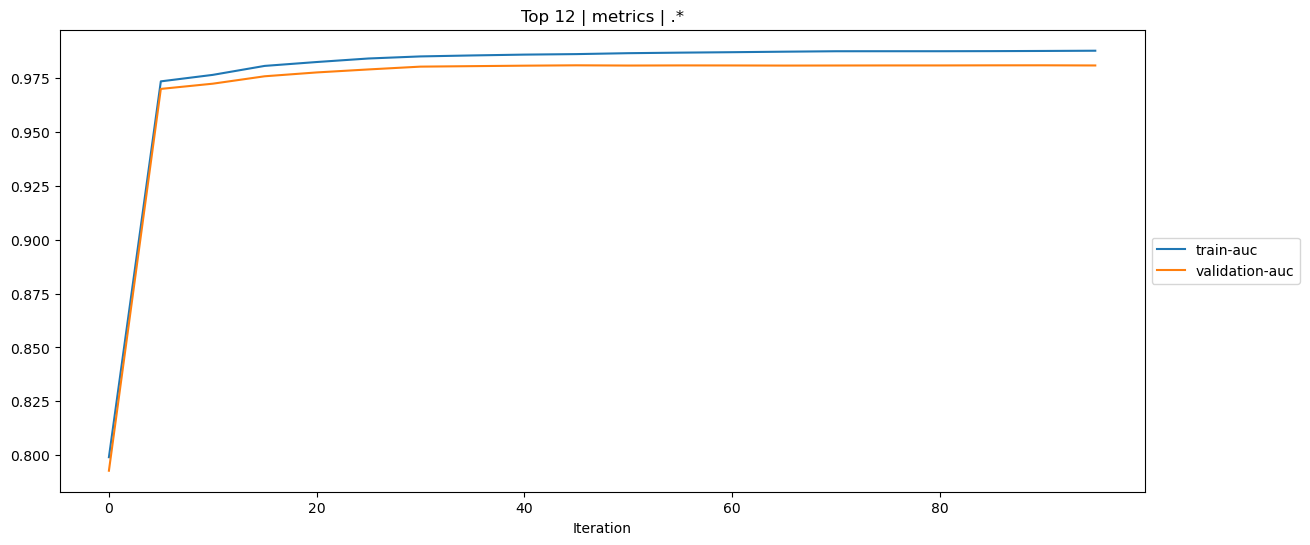

In [ ]:
plot_collection(trial, "metrics")

In [ ]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

matched tensors: 7 using regex: feature_importance/cover/.*


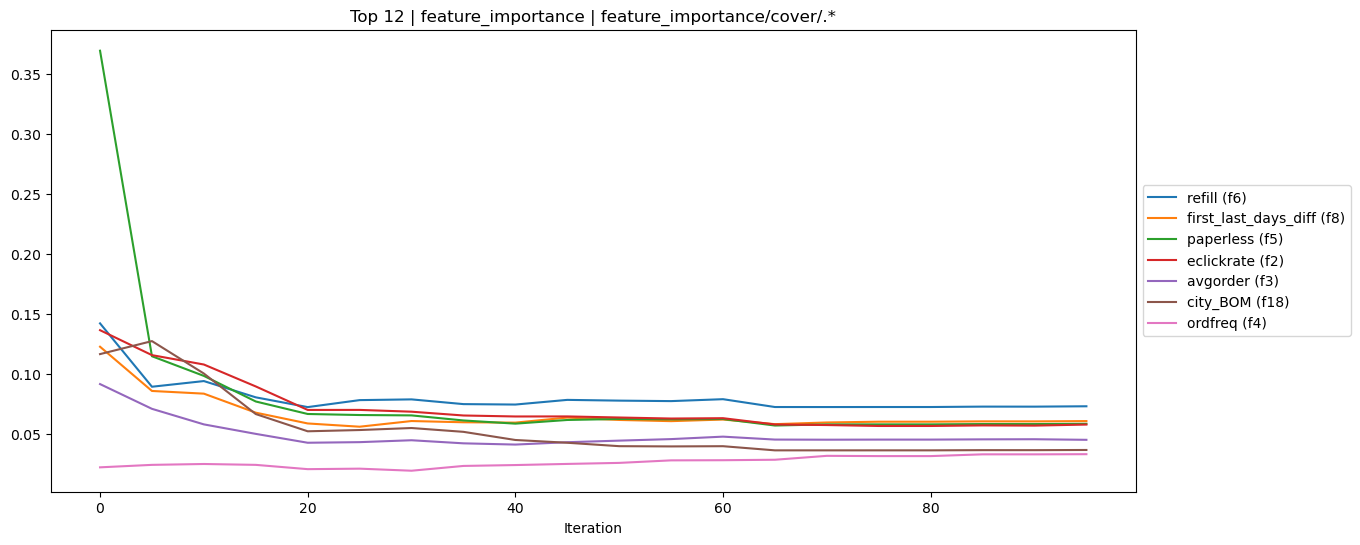

In [ ]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

matched tensors: 21 using regex: .*


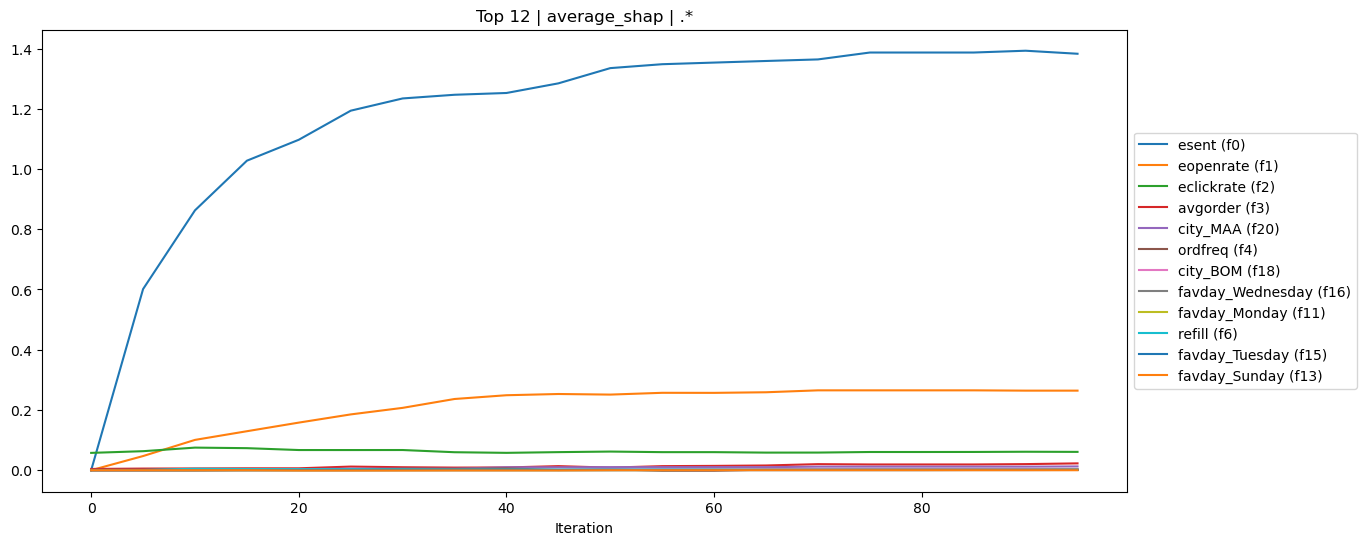

In [ ]:
plot_collection(trial, "average_shap")

### Global Explanations

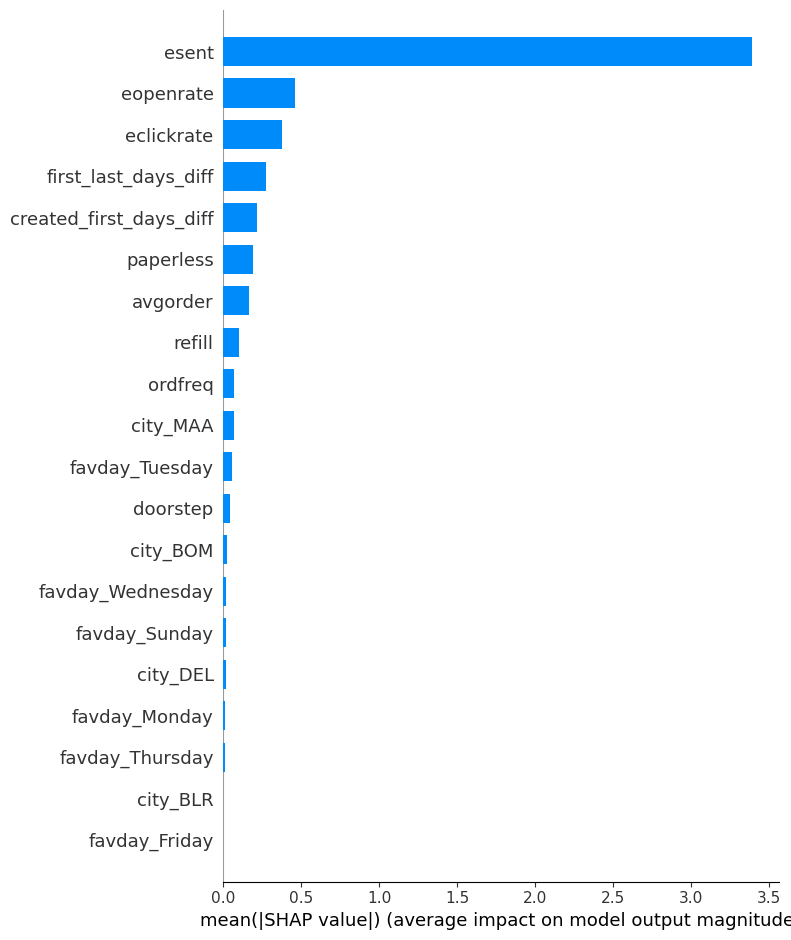

In [ ]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [ ]:
shap_base_value

np.float32(-0.015738394)

In [ ]:
def make_sagemaker_train_array(X, y):
    """
    Returns a NumPy array with:
    column 0 = label (y)
    columns 1.. = features (X)
    """
    df = pd.concat([y.rename("retained"), X], axis=1)
    return df.values
train = make_sagemaker_train_array(X_train, y_train)
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

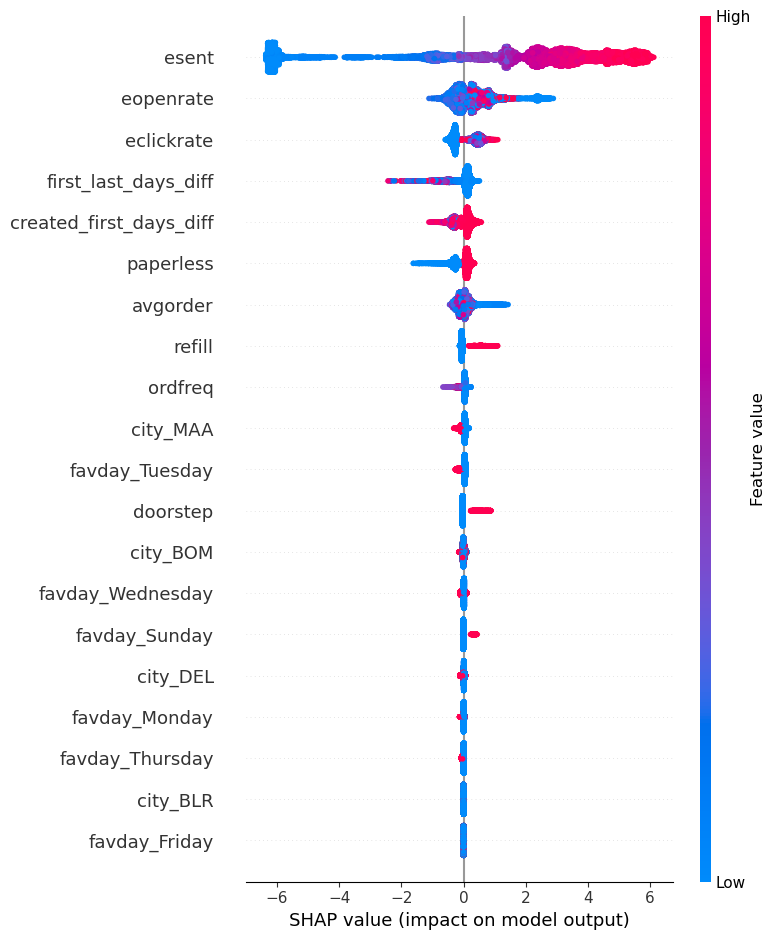

In [ ]:
shap.summary_plot(shap_no_base, train_shap)

### Local Explanations

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [ ]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [ ]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)